In [1]:
import os
import pandas as pd


def parse_log(path):
    with open(path) as f:
        lines = f.readlines()
    
    results = []
    for line in lines:
        if not 'success rate: ' in line:
            continue
        if 'Overall' in line:
            continue
        
        line = line.split(' - ')[1].strip()
        if line.endswith('.'):
            line = line[:-1]
        task, success_rate = line.split(' success rate: ')
        success_rate = float(success_rate)
        results.append({
            'task': task,
            'success_rate': success_rate
        })
    
    success_rates = [res['success_rate'] for res in results]
    results.append({
        'task': 'Overall',
        'success_rate': sum(success_rates) / len(success_rates)
    })
        
    return results

def read_dir(dir_):
    results = []
    for filename in os.listdir(dir_):
        epoch = int(filename.split('-')[0].split('_')[-1])
        results_ = parse_log(os.path.join(dir_, filename, '000.log'))
        for result in results_:
            result['epoch'] = epoch
            results.append(result)
    return results

result_root = '../results'
dfs = []
for name in os.listdir(result_root):
    if 'seed' in name:
        for dataset in os.listdir(os.path.join(result_root, name)):
            results = parse_log(os.path.join(result_root, name, dataset, '000.log'))
            for res in results:
                res['model'] = 'Baseline' if 'vqa' not in name else 'Ours'
                res['seed'] = name.split('_')[-1][4:]
                res['dataset'] = dataset
            dfs.append(pd.DataFrame(results))

df = pd.concat(dfs).replace('Overall', 'Total')
df = df[df['task'] == 'Total']

Text(0, 0.5, '')

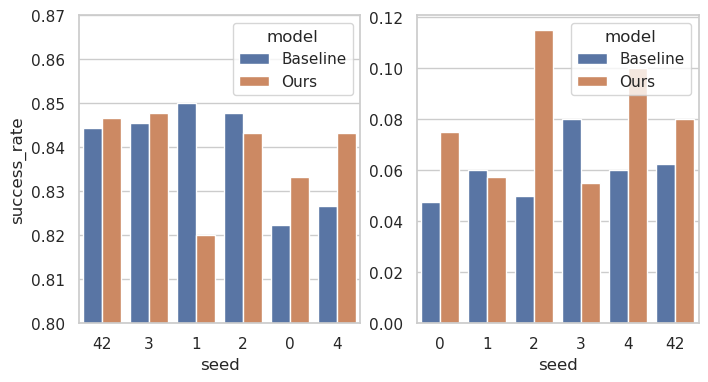

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.set_theme(style='whitegrid')
plt.subplot(1, 2, 1)
sns.barplot(df[df['dataset'] == 'libero_90'], x='seed', y='success_rate', hue='model')
plt.ylim(0.8, 0.87)

plt.subplot(1, 2, 2)
sns.barplot(df[df['dataset'] != 'libero_90'].drop(columns=['dataset', 'task']).groupby(['seed', 'model']).mean(), x='seed', y='success_rate', hue='model')
plt.ylabel('')
# plt.ylim(0.8, 0.88)

In [5]:
import numpy as np

df2 = df[df['seed'].isin(['0', '4', '42'])]
df2_unseen = df2[df2['dataset'] != 'libero_90']
df2_unseen = df2_unseen.drop(columns=['task', 'dataset']).groupby(['model', 'seed']).mean().reset_index()
df2_unseen['dataset'] = 'libero_unseen'
df2 = pd.concat([df2, df2_unseen])
df2 = df2.drop(columns=['task']).groupby(['model', 'dataset']).agg({'success_rate': [np.mean, np.std]}) * 100
df2.round(1).reset_index()

/tmp/ipykernel_60970/3470243748.py:8: FutureWarning: The provided callable <function mean at 0x151828e82d40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2 = df2.drop(columns=['task']).groupby(['model', 'dataset']).agg({'success_rate': [np.mean, np.std]}) * 100
/tmp/ipykernel_60970/3470243748.py:8: FutureWarning: The provided callable <function std at 0x151828e82e80> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df2 = df2.drop(columns=['task']).groupby(['model', 'dataset']).agg({'success_rate': [np.mean, np.std]}) * 100


model         dataset success_rate     
                                     mean  std
0   Baseline       libero_10          5.0  1.7
1   Baseline       libero_90         83.1  1.2
2   Baseline     libero_goal          6.0  3.0
3   Baseline   libero_object          6.0  5.3
4   Baseline  libero_spatial          5.7  7.2
5   Baseline   libero_unseen          5.7  0.8
6       Ours       libero_10          5.0  1.7
7       Ours       libero_90         84.1  0.7
8       Ours     libero_goal          6.0  1.0
9       Ours   libero_object         15.7  4.2
10      Ours  libero_spatial          7.3  3.8
11      Ours   libero_unseen          8.5  1.3